# **Solution Architecture**
### **Advanced-RAG-for-Finance-and-Market-Intelligence**


## 1. Business Problem

### Problem Identification
-  My aim in this project is to optimize business intelligence in BFSI and Marketing by leveraging advanced     **Retrieval-Augmented Generation (RAG)** pipelines and domain-adapted LLMs to deliver faster, deeper, and more reliable insights. 
- By streamlining the retrieval, filtering, and synthesis of financial and market data from complex, large-scale document sources, my solution empowers organizations to make smarter, data-driven decisions with greater speed and confidence.

### 🔧 Solution(Advanced RAG Overview) 

| **Stage**                | **Role / Specialty**                         | **Main Parameters / Components**                                                   | **Special Functions / Tools**                                              |
| ------------------------ | -------------------------------------------- | ---------------------------------------------------------------------------------- | -------------------------------------------------------------------------- |
| **1. Query Translation** | Decompose & rephrase business questions      | - LLMs (GPT-4)<br>- Multi-query chain<br>- Sub-question generator                  | Converts complex prompts into focused, industry-aware sub-questions        |
| **2. Routing**           | Direct queries to specialized domains        | - Semantic routing<br>- Domain prompt templates<br>- Embedding similarity          | Chooses correct context (e.g., finance vs. marketing) for tailored answers |
| **3. Indexing**          | Structure and vectorize knowledge base       | - Semantic Splitter<br>- RAPTOR summarization<br>- ColBERT<br>- Chroma Vectorstore | Smart chunking, hierarchical summaries, industry-tuned embedding models    |
| **4. Retrieval**         | Retrieve, filter, and rerank documents       | - Cohere Re-Rank<br>- CRAG graph<br>- ContextualCompressionRetriever               | High-precision semantic search, multi-step grading, hallucination checks   |
| **5. Generation**        | Synthesize clear, grounded business insights | - Self-RAG graph<br>- LLM ensemble (GPT-4/GPT-3.5)<br>- Prompt templates           | Final synthesis, grounding, answer quality grading, hallucination filter   |

### Complete Tech Stack
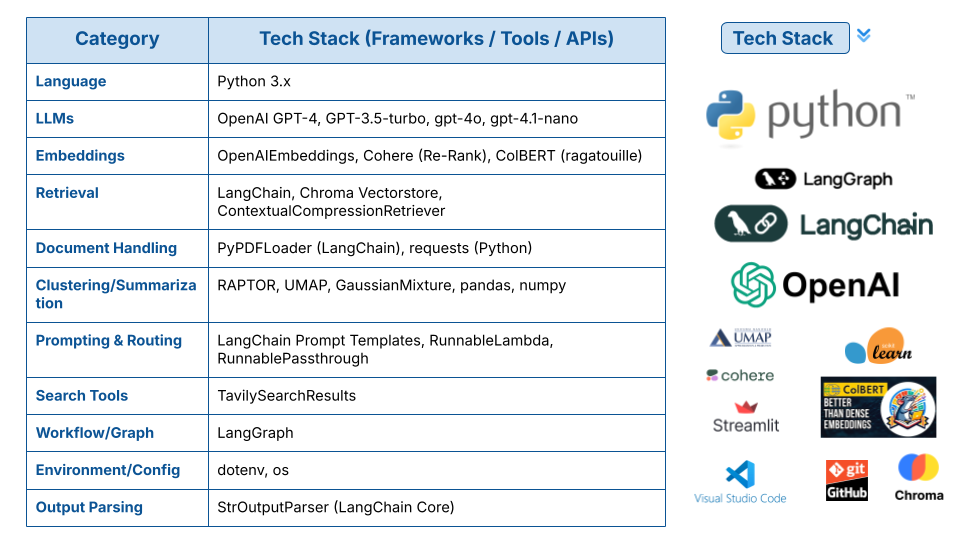

## 2. Initiation
| Step                       | Description                                                              |
|----------------------------|--------------------------------------------------------------------------|
| **Download & Load Reports**    | Fetch AI finance/market research PDF reports, split into pages, and store with metadata. |

### API_keys_env_setup

1. **Load Environment Variables**  
   - Retrieve API keys securely from a `.env` file to enable access for LLM and vector DB services.

In [123]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
if not os.getenv("OPENAI_API_KEY") or not os.getenv("LANGCHAIN_API_KEY"):
    raise RuntimeError("One or more API keys are missing in your .env file")

print("OPENAI_API_KEY  =", os.getenv("OPENAI_API_KEY"))
print("LANGCHAIN_API_KEY  =", os.getenv("LANGCHAIN_API_KEY"))
print("COHERE_API_KEY  =", os.getenv("COHERE_API_KEY"))
print("TRAVILY_API_KEY  =", os.getenv("TRAVILY_API_KEY"))
print("LANGCHAIN_ENDPOINT  =", os.getenv("LANGCHAIN_ENDPOINT"))
print("LANGCHAIN_TRACING_V2  =", os.getenv("LANGCHAIN_TRACING_V2"))
print("API keys have been set!")

### Documents Loading

1. Download multiple AI/finance reports as PDFs and load their pages using a document loader.
2. Store each page’s content with its report source for downstream processing.


In [39]:
import requests
from langchain_community.document_loaders import PyPDFLoader

In [ ]:
pdf_urls = [
    ("https://www.mckinsey.com/~/media/mckinsey/business%20functions/quantumblack/our%20insights/the%20state%20of%20ai/2025/the-state-of-ai-how-organizations-are-rewiring-to-capture-value_final.pdf", "mckinsey_ai_report"),
    ("https://media-publications.bcg.com/BCG-Wheres-the-Value-in-AI.pdf", "bcg_ai_report"),
    ("https://www.citiwarrants.com/home/upload/citi_research/rsch_pdf_30305836.pdf", "citigroup_ai_report")
]


In [74]:
all_docs = []
for url, report_name in pdf_urls:
    try:
        filename = f"{report_name}.pdf"
        print(f"Downloading: {report_name} ...")
        response = requests.get(url, timeout=60)
        response.raise_for_status()
        with open(filename, "wb") as f:
            f.write(response.content)
        loader = PyPDFLoader(filename)
        docs = loader.load()
        for doc in docs:
            doc.metadata["source"] = report_name
        all_docs.extend(docs)
        print(f"Loaded {len(docs)} pages from {report_name}")
    except Exception as e:
        print(f"Failed for {report_name}: {e}")


Downloading: mckinsey_ai_report ...
Loaded 26 pages from mckinsey_ai_report
Downloading: bcg_ai_report ...
Loaded 25 pages from bcg_ai_report
Downloading: citigroup_ai_report ...
Loaded 44 pages from citigroup_ai_report


In [ ]:

print(f"Loaded {len(all_docs)} pages total.")
print("\nSample page content:\n", all_docs[0].page_content[:500])
print("\nSample page source:", all_docs[0].metadata.get("source"))

Loaded 95 pages total.

Sample page content:
 The state of AI  
March 2025
Alex Singla  
Alexander Sukharevsky  
Lareina Yee  
Michael Chui  
Bryce Hall
How organizations are rewiring to capture value

Sample page source: mckinsey_ai_report


## 3. Indexing 
| Method               | Description                                                           | Key Steps                              | Best Use Case                                      |
|----------------------|-----------------------------------------------------------------------|----------------------------------------|----------------------------------------------------|
| **Semantic Splitter**| Splits text into overlapping, context-rich chunks for embeddings.     | Chunking, metadata retention, embedding| Simple, general-purpose document chunking & RAG    |
| **RAPTOR**           | Hierarchical clustering & summarization for compact, semantic indices.| Embedding, clustering, summarizing     | Large, complex docs; efficient retrieval; summaries|
| **ColBERT**          | Uses advanced token-level embeddings for high-precision retrieval.    | Indexing with ColBERT, top-k retrieval | Dense semantic search in specialized domains (BFSI)|


### Semantic Splitter (Chunking)


1. **Initialize the Text Splitter**  
   - Use `RecursiveCharacterTextSplitter` to create a splitter with defined chunk size and overlap.

2. **Split Documents into Chunks**  
   - For each document, divide content into overlapping text segments for improved context retention.

3. **Preserve Metadata**  
   - Optionally retain source or page metadata with each chunk for accurate traceability in downstream tasks.

4. **Prepare for Embedding**  
   - Collect all text chunks into a list (`leaf_texts`) for embedding and later retrieval.

5. **Set Up Embedding Model**  
   - Initialize the embedding model (e.g., `OpenAIEmbeddings`) to vectorize the prepared text chunks.


In [46]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [75]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=800, chunk_overlap=100
)

In [76]:
leaf_texts = []
for doc in all_docs:
    # Each chunk keeps original metadata for source/page reference
    splits = text_splitter.split_text(doc.page_content)
    for split in splits:
        # Optionally keep source/page info (not required, but nice for RAG)
        leaf_texts.append(split)


In [77]:
# 3. Set up embedding model (OpenAI in this example)
from langchain_openai import OpenAIEmbeddings
embd = OpenAIEmbeddings()

### RAPTOR-style: Embed, cluster, and summarize (Hierarchical Indexing)



1. **Embed and Cluster Chunks**
   - Convert document chunks to embeddings and reduce dimensionality (UMAP).
   - Cluster embeddings using Gaussian Mixture Models.

2. **Summarize Clusters**
   - For each cluster, select representative texts and summarize using an LLM.
   - Limit the size and number of texts for efficient summarization.

3. **Recursive Summarization**
   - Repeat clustering and summarization on summaries to build a hierarchical index.

4. **Aggregate All Texts**
   - Combine leaf chunks and all summaries into a final set for retrieval.

5. **Index for Retrieval**
   - Store all text chunks and summaries in a vector database for fast semantic search.


In [78]:
import numpy as np
import pandas as pd
import umap
from sklearn.mixture import GaussianMixture
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [84]:
# --- 1. Set model (use a cheaper model for intermediate summaries)
from langchain_openai import ChatOpenAI
model = ChatOpenAI(temperature=0, model="gpt-4.1-nano")  # use gpt-4 only for final answer if needed

In [85]:
def embed(texts):
    return np.array(embd.embed_documents(texts))

def global_cluster_embeddings(embeddings, dim=10, metric="cosine"):
    n_neighbors = max(2, int((len(embeddings) - 1) ** 0.5))
    return umap.UMAP(n_neighbors=n_neighbors, n_components=dim, metric=metric).fit_transform(embeddings)

def get_optimal_clusters(embeddings, max_clusters=30, random_state=224):
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]

def GMM_cluster(embeddings, threshold=0.1, random_state=0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

def perform_clustering(texts, dim=10, threshold=0.1):
    if len(texts) <= 2:
        # Not enough for clustering; just assign all to one cluster
        embeddings = embed(texts)
        return pd.DataFrame({"text": texts, "embd": list(embeddings), "cluster": [[0]] * len(texts)})
    embeddings = embed(texts)
    reduced = global_cluster_embeddings(embeddings, dim)
    cluster_labels, n_clusters = GMM_cluster(reduced, threshold)
    return pd.DataFrame({"text": texts, "embd": list(embeddings), "cluster": cluster_labels})

# --- 2. Truncate cluster size and max tokens for summarization
def summarize_cluster(texts, model, max_chunks=3, max_tokens=2000):
    from tiktoken import get_encoding
    enc = get_encoding("cl100k_base")
    # Only use the top max_chunks largest texts
    texts = sorted(texts, key=len, reverse=True)[:max_chunks]
    total = 0
    selected = []
    for t in texts:
        t_len = len(enc.encode(t))
        if total + t_len > max_tokens:
            break
        selected.append(t)
        total += t_len
    context = "\n\n".join(selected)
    prompt = "Summarize the following documentation for knowledge retrieval:\n{context}"
    chain = ChatPromptTemplate.from_template(prompt) | model | StrOutputParser()
    return chain.invoke({"context": context})



In [ ]:
#Hierarchically summarize clusters and build tree
#Recursive clustering & summarization, print API call stats
api_calls = 0

def recursive_cluster_summarize(texts, model, n_levels=2, level=1, results=None):
    global api_calls
    if results is None:
        results = {}
    df = perform_clustering(texts)
    results[level] = df
    clusters = []
    for c in df['cluster']:
        clusters.extend(c)
    unique_clusters = set(clusters)
    if len(unique_clusters) > 1 and level < n_levels:
        for cluster in unique_clusters:
            cluster_texts = df[[cluster in cl for cl in df['cluster']]]['text'].tolist()
            summary = summarize_cluster(cluster_texts, model)
            api_calls += 1
            # Early stop if too many calls
            if api_calls > 20:
                print("Stopping early: too many API calls!")
                return results
            recursive_cluster_summarize([summary], model, n_levels, level+1, results)
    return results

In [90]:
# --- 4. Run the clustering & summarization (max levels = 2)
results = recursive_cluster_summarize(leaf_texts, model, n_levels=2)
print(f"Total summarization API calls: {api_calls}")

Total summarization API calls: 13


In [ ]:
# Flatten all leaf_texts and all unique summaries from all levels
all_texts = leaf_texts.copy()
for lvl, df in results.items():
    if "summary" in df.columns:
        all_texts.extend(df["summary"].tolist())

In [ ]:
#Indexing in a vectorstore (RAPTOR-style)
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_texts(texts=all_texts, embedding=embd)
retriever = vectorstore.as_retriever()

In [98]:
# 8. Now use the retriever in a RAG chain
from langchain import hub
from langchain_core.runnables import RunnablePassthrough

prompt = hub.pull("rlm/rag-prompt")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

# Example query
print(rag_chain.invoke("How is AI adoption transforming fraud detection and risk management in the financial sector?"))


AI adoption is transforming fraud detection and risk management by enabling more precise and efficient identification of fraudulent activities, such as deepfake manipulation and scams. AI models can analyze large volumes of data, automate compliance processes, and reduce false positives, saving time and costs for financial institutions. This shift is part of a broader trend where AI is moving from proof of concept to real-world, scalable applications that enhance security and regulatory compliance.


### Advanced Embeddings & Semantic Search (ColBERT)


1. **Load Pretrained ColBERT Model**
   - Initialize ColBERT using `RAGPretrainedModel` for high-quality embeddings.

2. **Index Text Chunks**
   - Index all document chunks or summaries for fast retrieval.

3. **Retrieve Relevant Chunks**
   - Use ColBERT retriever to find top-k relevant documents for a query.

4. **Integrate with RAG Pipeline**
   - Optionally, combine the retriever with LLMs for final answer generation.

5. **Example Use Case**
   - Query: “How is AI adoption transforming risk management in the financial sector?”


In [ ]:
from ragatouille import RAGPretrainedModel

In [ ]:
RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

In [ ]:
# 3. Index your local documents/chunks (from your RAPTOR/semantic splitter step)
# Suppose you have: all_texts = [...] # List of strings (chunks/summaries)

index_name = "my_rag_index"
RAG.index(
    collection=all_texts,
    index_name=index_name,
    max_document_length=180,  # adjust for your docs, 180 tokens default
    split_documents=True,     # splits long docs into multiple passages
)


In [ ]:
# 4. Use ColBERT as a retriever for semantic search in your RAG pipeline
retriever = RAG.as_langchain_retriever(k=3)  # k = number of docs to retrieve

# Example query relevant to AI adoption in BFSI:
query = "How is AI adoption transforming risk management in the financial sector?"
docs = retriever.invoke(query)
for i, doc in enumerate(docs, 1):
    print(f"Document {i}:\n{doc.page_content[:400]}\n")


In [ ]:
# 5. (Optional) Use in LangChain RAG chain with a prompt/model (if desired)
from langchain import hub
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Example RAG answer
print(rag_chain.invoke(query))


## 4. Query Transaltion
| Step                                 | Description                                                         |
|-------------------------------------- |---------------------------------------------------------------------|
| **Decompose Complex Query**           | Use an LLM prompt to break a broad question into focused sub-questions. |
| **Retrieve & Answer Each Sub-Question** | For each sub-question, retrieve relevant context and generate a concise answer using an LLM. |
| **Synthesize Final Answer**           | Aggregate all Q&A pairs and prompt the LLM to compose a single, comprehensive response.      |


### Multi-query decomposition

1. **Define a Decomposition Prompt**  
   - Create a prompt template that instructs the LLM to break down complex questions into sub-questions.

2. **Run the LLM Chain**  
   - Use the prompt with a language model (e.g., GPT-4) to generate relevant sub-questions.

3. **Split Output into Sub-Questions**  
   - Parse and collect the generated sub-questions for downstream retrieval and answer synthesis.


In [ ]:
#Multi-query decomposition-break complex question into sub-questions
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

template = """
You are a helpful assistant that generates multiple sub-questions for an input question.
Break down: {question}
Output (3 queries):
"""

In [ ]:
prompt_decomposition = ChatPromptTemplate.from_template(template)
llm = ChatOpenAI(model="gpt-4", temperature=0)
multi_query_chain = (
    prompt_decomposition | llm | StrOutputParser() | (lambda x: x.split("\n"))
)


In [12]:
question = "How are companies across different domains and industries adopting the AI revolution?"
sub_questions = multi_query_chain.invoke({"question": question})
sub_questions

['1. What specific AI technologies are companies in the tech industry implementing compared to companies in traditional industries like manufacturing or healthcare?',
 '2. How are companies in different domains approaching the integration of AI into their existing processes and systems?',
 '3. What challenges are companies facing in adopting AI across various industries, and how are they overcoming these obstacles?']

### Retrieve and generate an answer for each sub-question (RAG)

1. **Format Each Sub-Question**  
   - For every sub-question, retrieve relevant documents using the retriever.

2. **Generate Contextual Answer**  
   - Use an LLM with a RAG prompt to answer each sub-question based on the retrieved context.

3. **Collect Answers**  
   - Store the concise answers for downstream synthesis or reporting.


In [ ]:
#Retrieve and generate an answer for each sub-question (RAG)
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

rag_template = """
Context:
{context}

Question:
{question}

Answer concisely:
"""

In [14]:
prompt_rag = ChatPromptTemplate.from_template(rag_template)
llm = ChatOpenAI(model="gpt-4", temperature=0)

In [ ]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
answers = []
for sq in sub_questions:
    docs = retriever.get_relevant_documents(sq)
    context = format_docs(docs)
    answer = (prompt_rag | llm | StrOutputParser()).invoke({"context": context, "question": sq})
    answers.append(answer)


C:\Users\Patil Shinde\AppData\Local\Temp\ipykernel_10364\127589085.py:6: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(sq)


In [16]:
answers

['The text does not provide specific details on the AI technologies that companies in the tech industry are implementing compared to companies in traditional industries like manufacturing or healthcare.',
 'Companies in different domains are integrating AI into their existing processes and systems in various ways. For instance, media and telecommunication companies are using AI in service operations, technology companies are using it in software engineering, and professional-services organizations are using it in knowledge management. The integration of AI also varies by company size, with larger companies with more than $500 million in annual revenues using AI throughout more of their organizations than smaller companies. These companies are also more likely to hire a broad range of AI-related roles. As organizations become more fluent with AI, it is becoming embedded in all functions, allowing leadership to focus on higher-level tasks.',
 'Companies face challenges such as establishi

### Synthesize a final answer using all Q&A pairs (Self-RAG)

1. **Aggregate Q&A Pairs**  
   - Format sub-questions and their answers as a combined context.

2. **Compose Comprehensive Prompt**  
   - Use a synthesis prompt to instruct the LLM to integrate all Q&A pairs.

3. **Generate Final Answer**  
   - Invoke the LLM to produce a single, coherent answer based on all prior responses.


In [ ]:
#Synthesize a final answer using all Q&A pairs (Self-RAG)
def format_qa_pairs(questions, answers):
    return "\n".join([f"Question: {q}\nAnswer: {a}" for q, a in zip(questions, answers)])

context = format_qa_pairs(sub_questions, answers)

In [18]:
final_template = """
Here are Q&A pairs:

{context}

Use these to write a comprehensive answer to the question:
{question}
"""

In [19]:
final_prompt = ChatPromptTemplate.from_template(final_template)

In [20]:
final_answer = (
    final_prompt
    | llm
    | StrOutputParser()
).invoke({"context": context, "question": question})


In [ ]:
print(final_answer)

Companies across different domains and industries are adopting the AI revolution in a variety of ways. For instance, media and telecommunication companies are integrating AI into their service operations, while technology companies are using AI in software engineering. Professional-services organizations, on the other hand, are utilizing AI in knowledge management. The extent of AI integration also varies depending on the size of the company. Larger companies with more than $500 million in annual revenues are using AI throughout more of their organizations compared to smaller companies. These larger companies are also more likely to hire a broad range of AI-related roles.

However, the adoption of AI is not without challenges. Companies are grappling with issues such as establishing a compelling change story for AI adoption, tracking KPIs for AI solutions, creating employee incentives for AI adoption, and fostering trust among customers in their use of AI. To overcome these obstacles, 

## 5. Routing
| Method              | Description                                                        | Key Steps                                    |
|---------------------|--------------------------------------------------------------------|----------------------------------------------|
| **Semantic Routing**| Dynamically routes queries to domain-specific expert prompts using semantic similarity. | Embed prompts & query → Compute similarity → Route to domain prompt → LLM answer |


### semantic routing after multi-query translation

1. **Define Domain-Specific Prompts**  
   - Prepare expert prompts tailored to different industries (e.g., tech, manufacturing).

2. **Embed Prompts and Query**  
   - Compute embeddings for both domain prompts and user queries.

3. **Calculate Similarity**  
   - Measure similarity between query and prompt embeddings to select the most relevant domain.

4. **Route and Answer Each Sub-Question**  
   - Direct each sub-question to the matched expert prompt, then generate answers with the LLM.

5. **Aggregate Domain-Specific Answers**  
   - Collect and display responses for all sub-questions, ensuring context-aware answers.


In [22]:
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain.utils.math import cosine_similarity
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

In [ ]:
# Domain prompts
tech_template = """You are an expert on AI adoption in technology companies.
Provide practical insights and examples of how tech industry leaders use AI, including specific technologies and impact.

Here is a question:
{query}"""

manufacturing_template = """You are an expert on AI in manufacturing and traditional industries.
Explain how companies in manufacturing or healthcare use AI, with focus on challenges and integration processes.

Here is a question:
{query}"""

In [ ]:
domain_templates = [tech_template, manufacturing_template]
embeddings = OpenAIEmbeddings()
template_embeddings = embeddings.embed_documents(domain_templates)

In [25]:
def semantic_prompt_router(input):
    query_embedding = embeddings.embed_query(input["query"])
    similarity = cosine_similarity([query_embedding], template_embeddings)[0]
    idx = similarity.argmax()
    selected_template = domain_templates[idx]
    routed = "TECH" if idx == 0 else "MANUFACTURING/HEALTHCARE"
    print(f"ROUTED TO: {routed}")
    return ChatPromptTemplate.from_template(selected_template)

In [26]:
# Multi-query sub-questions (from your earlier step)
sub_questions = [
    "What specific AI technologies are companies in the tech industry implementing compared to companies in traditional industries like manufacturing or healthcare?",
    "How are companies in different domains approaching the integration of AI into their existing processes and systems?",
    "What challenges are companies facing in adopting AI across various industries, and how are they overcoming these obstacles?"
]

In [27]:
llm = ChatOpenAI(model="gpt-4", temperature=0)

In [28]:
final_answers = []
for q in sub_questions:
    chain = (
        {"query": RunnablePassthrough()}
        | RunnableLambda(semantic_prompt_router)
        | llm
        | StrOutputParser()
    )
    answer = chain.invoke(q)
    final_answers.append({"question": q, "answer": answer})


ROUTED TO: MANUFACTURING/HEALTHCARE
ROUTED TO: MANUFACTURING/HEALTHCARE
ROUTED TO: MANUFACTURING/HEALTHCARE


In [ ]:
for qa in final_answers:
    print(f"\nQuestion: {qa['question']}\nAnswer: {qa['answer']}\n")


Question: What specific AI technologies are companies in the tech industry implementing compared to companies in traditional industries like manufacturing or healthcare?
Answer: Companies in the tech industry are implementing a wide range of AI technologies, including machine learning, natural language processing, robotics, and computer vision. These technologies are used for various purposes such as data analysis, automation of tasks, customer service, and product development.

In contrast, companies in traditional industries like manufacturing and healthcare are also implementing AI technologies, but their focus may be slightly different. In manufacturing, AI is often used for predictive maintenance, quality control, demand forecasting, and supply chain optimization. For instance, machine learning algorithms can analyze data from machinery to predict when maintenance is needed, reducing downtime. Computer vision can be used to inspect products and identify defects, improving quality

## 6. Retrieval 
| Method          | Description                                                                                  | Key Steps                                                                 |
|-----------------|----------------------------------------------------------------------------------------------|---------------------------------------------------------------------------|
| **Re-Rank**     | Rerank initially retrieved documents using Cohere Re-Rank for optimal relevance.             | Retrieve documents, rerank for relevance, format context, generate answer. |
| **CRAG**        | Refine, grade, and synthesize answers through iterative retrieval, filtering, and generation.| Retrieve and grade docs, generate answer, refine query, use web search if needed, iterate for best result. |


### Re-Rank

1. **Set Up Re-Ranker**  
   - Use Cohere Re-Rank to rerank initially retrieved documents for a query.

2. **Retrieve and Rerank**  
   - Get top-ranked documents most relevant to the user’s question.

3. **Format Context**  
   - Combine reranked documents into a coherent context for the LLM.

4. **Generate Answer**  
   - Prompt the LLM with this context to produce a high-quality, context-grounded answer.


In [ ]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CohereRerank

In [ ]:
#Set up Cohere Re-Rank compression retriever
compressor = CohereRerank(model="rerank-english-v3.0")  
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=retriever,
)

In [ ]:
#Retrieve and rerank documents for a given query
question = "How is AI adoption transforming risk management in the financial sector?"
reranked_docs = compression_retriever.get_relevant_documents(question)

In [ ]:
#Format context for  LLM answer
context = "\n\n".join(doc.page_content for doc in reranked_docs)

In [ ]:
#Generate answer with LLM using retrieved context
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

In [110]:
prompt = ChatPromptTemplate.from_template(
    "Answer the following question based on this context:\n\n{context}\n\nQuestion: {question}"
)
llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")

In [111]:
final_prompt = prompt.invoke({"context": context, "question": question})
answer = llm.invoke(final_prompt)
print(answer)

content='AI adoption is transforming risk management in the financial sector by enabling organizations to mitigate risks more effectively. Larger organizations are reported to be managing potential cybersecurity and privacy risks better than others through the use of AI. However, they are not necessarily addressing risks related to the accuracy or explainability of AI outputs more than others. This indicates that AI adoption is helping financial institutions improve their risk management practices, particularly in areas such as cybersecurity and privacy. Additionally, AI adoption in risk management is allowing organizations to identify and address potential risks more efficiently, ultimately enhancing their overall risk management strategies.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 113, 'prompt_tokens': 1333, 'total_tokens': 1446, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0,

### Refinement and Retrieva (CRAG)

1. **Retrieve Candidate Documents**  
   - Use a retriever to collect relevant documents for the input question.

2. **Grade Document Relevance**  
   - Automatically filter documents using an LLM grader to ensure high relevance.

3. **Generate and Synthesize Answer**  
   - Aggregate content from filtered docs and generate an answer with a RAG LLM chain.

4. **Refine Query if Needed**  
   - If no relevant docs found, rewrite and retry the question for improved retrieval.

5. **Web Search Fallback**  
   - Optionally fetch additional context via web search when in-domain sources are insufficient.

6. **Iterate Until Confident Answer**  
   - Continue refining and synthesizing until a strong, supported answer is produced.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.schema import Document
from langgraph.graph import END, StateGraph, START
from typing import List
from typing_extensions import TypedDict

In [ ]:
class GradeDocuments(BaseModel):
    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

llm_grader = ChatOpenAI(model="gpt-4o-mini", temperature=0).with_structured_output(GradeDocuments)
grade_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a grader assessing relevance of a retrieved document to a user question. If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. Give a binary score 'yes' or 'no'."),
    ("human", "Retrieved document:\n\n {document} \n\n User question: {question}"),
])
retrieval_grader = grade_prompt | llm_grader

c:\Users\Patil Shinde\.conda\envs\rag_llm\lib\site-packages\langchain_openai\chat_models\base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


In [ ]:
#RAG Generation Chain
prompt = hub.pull("rlm/rag-prompt")
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
rag_chain = prompt | llm | StrOutputParser()

re_write_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a question re-writer that converts an input question to a better version that is optimized for web search. Look at the input and try to reason about the underlying semantic intent / meaning."),
    ("human", "Here is the initial question:\n\n {question} \n Formulate an improved question."),
])
question_rewriter = re_write_prompt | llm | StrOutputParser()

In [ ]:
web_search_tool = TavilySearchResults(k=3, tavily_api_key="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")

In [ ]:
#Graph State
class GraphState(TypedDict):
    question: str
    generation: str
    web_search: str
    documents: List[Document]

In [ ]:
#Graph Nodes
def retrieve(state):
    docs = retriever.get_relevant_documents(state["question"])
    return {"documents": docs, "question": state["question"]}

def grade_documents(state):
    question, documents = state["question"], state["documents"]
    filtered_docs, web_search = [], "No"
    for d in documents:
        grade = retrieval_grader.invoke({"question": question, "document": d.page_content}).binary_score
        if grade == "yes":
            filtered_docs.append(d)
        else:
            web_search = "Yes"
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

def generate(state):
    context = "\n\n".join(doc.page_content for doc in state["documents"])
    generation = rag_chain.invoke({"context": context, "question": state["question"]})
    return {"documents": state["documents"], "question": state["question"], "generation": generation}

def transform_query(state):
    better_question = question_rewriter.invoke({"question": state["question"]})
    return {"documents": state["documents"], "question": better_question}

def web_search(state):
    docs = web_search_tool.invoke({"query": state["question"]})
    web_results = Document(page_content="\n".join([d["content"] for d in docs]))
    return {"documents": state["documents"] + [web_results], "question": state["question"]}

def decide_to_generate(state):
    return "transform_query" if state["web_search"] == "Yes" else "generate"


In [ ]:
#Buildingf Graph 
workflow = StateGraph(GraphState)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search_node", web_search)
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges("grade_documents", decide_to_generate, {
    "transform_query": "transform_query",
    "generate": "generate",
})
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)
app = workflow.compile()

In [ ]:
#Runnning Graph 
from pprint import pprint
inputs = {"question": "In what ways can AI-powered predictive analytics enhance investment strategies?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")

"Node 'retrieve':"
'\n---\n'
"Node 'grade_documents':"
'\n---\n'
"Node 'transform_query':"
'\n---\n'
"Node 'web_search_node':"
'\n---\n'
"Node 'generate':"
'\n---\n'


In [138]:
# Final generation
pprint(value["generation"])

('AI-driven predictive analytics can improve investment strategies by '
 'providing real-time insights, enhancing risk assessment, and enabling better '
 "forecasting for higher returns. Understanding AI's impact is crucial for "
 'staying ahead in the investment world and gaining a competitive edge. '
 'Embracing these tools can lead to improved overall strategy effectiveness.')


In [ ]:
print(workflow.nodes)
print(workflow.edges)

{'retrieve': StateNodeSpec(runnable=retrieve(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None, input=<class '__main__.GraphState'>, retry_policy=None, cache_policy=None, ends=(), defer=False), 'grade_documents': StateNodeSpec(runnable=grade_documents(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None, input=<class '__main__.GraphState'>, retry_policy=None, cache_policy=None, ends=(), defer=False), 'generate': StateNodeSpec(runnable=generate(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None, input=<class '__main__.GraphState'>, retry_policy=None, cache_policy=None, ends=(), defer=False), 'transform_query': StateNodeSpec(runnable=transform_query(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None, input=<class '__main__.GraphState'>, retry_policy=None, cache_policy=None, ends=(

## 7. Generation
| Method     | Description                                                        | Key Steps                                            |
|------------|--------------------------------------------------------------------|------------------------------------------------------|
| **Self-RAG** | Retrieves, filters, and refines answers through LLM-based grading and iterative improvement. | Retrieve → Grade docs → Generate → Grade answer → Iterate if needed |


### Self-RAG

1. **Retrieve Documents**  
   - Use a retriever to gather candidate documents for the input question.

2. **Grade Document Relevance**  
   - Apply LLM grading to filter out irrelevant results.

3. **Generate Initial Answer**  
   - Combine filtered context and question; generate an answer via RAG.

4. **Grade Hallucination and Answer Quality**  
   - Automatically check if the answer is grounded and truly addresses the question.

5. **Iterate if Needed**  
   - If answer is unsatisfactory, repeat steps for improved results, ensuring accuracy and completeness.


In [143]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain import hub
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from pprint import pprint

In [ ]:
# Defining Data Models for LLM Grading

class GradeDocuments(BaseModel):
    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

class GradeHallucinations(BaseModel):
    binary_score: str = Field(description="Answer is grounded in the facts, 'yes' or 'no'")

class GradeAnswer(BaseModel):
    binary_score: str = Field(description="Answer addresses the question, 'yes' or 'no'")


In [ ]:
#Prompts and LLM Chains

llm_gpt4o = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_gpt35 = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


In [146]:
# Document Relevance Grader
grade_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a grader assessing relevance of a retrieved document to a user question. If the document contains keywords or semantic meaning related to the question, grade it as relevant. Give a binary score 'yes' or 'no'."),
    ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
])
retrieval_grader = grade_prompt | llm_gpt4o.with_structured_output(GradeDocuments)


c:\Users\Patil Shinde\.conda\envs\rag_llm\lib\site-packages\langchain_openai\chat_models\base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


In [147]:
# Hallucination Grader
hallucination_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. Give a binary score 'yes' or 'no'."),
    ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
])
hallucination_grader = hallucination_prompt | llm_gpt4o.with_structured_output(GradeHallucinations)


In [148]:
# Answer Grader
answer_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a grader assessing whether an answer addresses / resolves a question. Give a binary score 'yes' or 'no'."),
    ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
])
answer_grader = answer_prompt | llm_gpt4o.with_structured_output(GradeAnswer)


In [149]:
# RAG Prompt
prompt = hub.pull("rlm/rag-prompt")
rag_chain = prompt | llm_gpt35 | StrOutputParser()

In [ ]:
#Graph State Definition 
class GraphState(TypedDict):
    question: str
    generation: str
    documents: List[str]

In [ ]:
#Core Pipeline Nodes
def retrieve(state):
    # Retrieval step,
    question = state["question"]
    documents = retriever.invoke(question)  
    return {"documents": documents, "question": question}

def grade_documents(state):
    # LLM-based document relevance grading
    question, documents = state["question"], state["documents"]
    filtered_docs = [
        d for d in documents
        if retrieval_grader.invoke({"question": question, "document": d.page_content}).binary_score == "yes"
    ]
    return {"documents": filtered_docs, "question": question}

def generate(state):
    # Generate answer from context and question
    context = "\n\n".join(doc.page_content for doc in state["documents"])
    generation = rag_chain.invoke({"context": context, "question": state["question"]})
    return {"documents": state["documents"], "question": state["question"], "generation": generation}

def decide_to_generate(state):
    # If docs exist, generate. else, fallback logic
    return "generate" if state["documents"] else "transform_query"

def grade_generation_v_documents_and_question(state):
    # Grade hallucination and answer quality
    question, documents, generation = state["question"], state["documents"], state["generation"]
    hallucination_score = hallucination_grader.invoke({"documents": documents, "generation": generation}).binary_score
    if hallucination_score == "yes":
        answer_score = answer_grader.invoke({"question": question, "generation": generation}).binary_score
        return "useful" if answer_score == "yes" else "not useful"
    else:
        return "not supported"

In [ ]:
#Building and Running the Workflow Graph
workflow = StateGraph(GraphState)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges("grade_documents", decide_to_generate, {
    "generate": "generate",
    "transform_query": "retrieve",  # fallback logic 
})
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "useful": END,
        "not useful": "retrieve",
        "not supported": "generate",
    },
)
app = workflow.compile()

In [ ]:
#Examplee-
inputs = {"question": "How can AI be used to improve customer personalization in financial services?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")

"Node 'retrieve':"
'\n---\n'
"Node 'grade_documents':"
'\n---\n'
"Node 'generate':"
'\n---\n'


In [ ]:
# Final generation (the Synthesizedd answer)
pprint(value["generation"])

('AI can be used in financial services to drive hyper-personalization by '
 'analyzing data in real-time to offer tailored experiences and '
 'recommendations. This allows businesses to adapt to individual preferences, '
 'behaviors, and needs, creating personalized products, services, and '
 'marketing campaigns. Financial firms are investing in hyper-personalization '
 'efforts to deliver consumer and merchant insights, driving the development '
 'of new platforms, products, and services.')


## 8. Conclusion

- This project, **Advanced RAG for Business Intelligence**, demonstrates how modern Retrieval-Augmented Generation (RAG) methods—combined with domain-adaptive query translation, semantic routing, and advanced vector search—can transform business intelligence in BFSI and Marketing. 
- Each pipeline stage, from semantic document splitting and hierarchical clustering to reranking and answer synthesis, has been precisely engineered to deliver fast, trustworthy, and context-rich answers for complex business questions.


**Structured RAG Pipeline Achievements**

| **Stage**                  | **Key Achievement & Role**                                                                                                    |
|----------------------------|-----------------------------------------------------------------------------------------------------------------------------|
| **Data Acquisition**       | Automated, secure loading of business/financial reports (PDFs, web data) into a high-value, domain-specific corpus.         |
| **Semantic Splitting & Indexing** | Fine-grained chunking with RecursiveCharacterTextSplitter, RAPTOR, and ColBERT, enabling high-accuracy, context-aware retrieval. |
| **Query Translation & Multi-Query** | Complex business questions are decomposed into focused sub-questions for richer and more relevant answer coverage.      |
| **Semantic Routing**       | Each sub-query is routed to the most appropriate expert prompt via embedding similarity for tailored business insight.       |
| **Advanced Retrieval & Re-Ranking** | Uses ColBERT, Chroma, and Cohere ReRank to prioritize the most relevant and factual information for each business query.|
| **Generation & Synthesis** | Fuses retrieved context with LLMs (OpenAI GPT-4/3.5), supporting self-RAG and answer grading for reliable business outputs.  |
| **Evaluation & Traceability** | LLM-based grading ensures answer quality and source traceability for robust, auditable results.                             |


**Business & Technical Value Delivered**

* **Rapid, Actionable Insights:** Delivers clear, trusted business intelligence from large and complex data sources, accelerating research, analysis, and strategic decisions.
* **Domain Flexibility:** Adapts to various BFSI and marketing use cases with modular stages for multi-query, routing, and answer evaluation.
* **Transparency & Extensibility:** Every answer is traceable; the pipeline supports quick integration of new data sources, models, or business needs.

## 9. Future Scope

- I believe this project can be further enhanced by incorporating additional technical features and deeper domain-specific capabilities. 
- Expanding both the technical infrastructure and domain adaptations will ensure even greater value, scalability, and relevance for advanced business intelligence applications in BFSI and marketing.

**Technical Advancements**

- **Multi-Modal Retrieval:** Integrate image, table, and audio processing (e.g., OCR, Tabular RAG, speech-to-text) for richer context, especially from annual reports, presentations, and webinars.
- **Real-Time Data Integration:** Connect RAG pipeline to live financial feeds, market APIs, and news streams for up-to-date intelligence and event-driven insights.
- **Personalized Agent Routing:** Deploy user-profile or department-aware semantic routers to customize responses for compliance, risk, sales, or marketing teams.
- **Fine-Tuned Models:** Train domain-specific embedding models and LLMs (e.g., FinBERT, BloombergGPT, or custom OpenAI/Cohere models) to further boost retrieval relevance and answer quality.
- **Feedback-Driven Learning:** Implement human-in-the-loop feedback and active learning pipelines to iteratively refine RAG, retrieval, and grading logic.
- **Explainability and Auditing:** Develop advanced traceability features—such as interactive source tracking, answer attribution, and regulatory audit logs.




**Domain Expansion**

- **ESG & Regulatory Compliance:** Adapt the pipeline for ESG (Environmental, Social, Governance) analysis and fast-moving regulatory updates.
- **Risk & Fraud Intelligence:** Extend RAG to anti-fraud use cases by ingesting transactional and behavioral datasets, supporting proactive risk management.
- **Customer Intelligence & Personalization:** Leverage RAG to enable highly personalized marketing, churn prediction, and customer support automation in banking and insurance.
- **Cross-Industry Verticalization:** Package the workflow for other domains, such as healthcare claims, supply chain analytics, or insurance underwriting, where trustworthy retrieval and synthesis are critical.

This roadmap positions Advanced RAG as a foundation for truly dynamic, adaptive, and explainable business intelligence ready for the evolving demands of BFSI, marketing, and beyond.

## 10. References

1. **Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks**
   *Patrick Lewis et al., NeurIPS 2020*
   🔗 [Paper](https://arxiv.org/abs/2005.11401)

   > **Overview:** Introduces the RAG framework, combining neural retrieval with generative models for open-domain QA—forms the backbone of retrieval-augmented pipelines used in this project.

2. **ColBERT: Efficient and Effective Passage Search via Contextualized Late Interaction over BERT**
   *Omar Khattab & Matei Zaharia, SIGIR 2020*
   🔗 [Paper](https://arxiv.org/abs/2004.12832)

   > **Overview:** Presents the ColBERT method for scalable, high-quality neural retrieval—enabling semantic search and re-ranking in enterprise-scale RAG systems.

3. **LangChain Documentation: Building Applications with LLMs**
   *Harrison Chase et al., LangChain Docs, 2023*
   🔗 [Docs](https://python.langchain.com/docs/)

   > **Overview:** The official documentation for LangChain, providing best practices and advanced patterns for modular, composable retrieval and generation workflows.

4. **Cohere ReRank API Reference**
   *Cohere, 2023*
   🔗 [Docs](https://docs.cohere.com/docs/rerank)

   > **Overview:** Official documentation for Cohere’s neural re-ranking API, essential for fine-tuned, top-k document selection and advanced retrieval refinement.